In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


How are you?

How - [0.3,0.4,0.1]
are - [0.1,0.8,0.4]
you - [0.2,0.4,0.6]

<!-- You come - [0.3,0.4,0.1],[0.1,0.8,0.4]
you come - [0.3,0.4,0.1],[0.1,0.8,0.4] -->
final sentence - [[0.3,0.4,0.1],[0.1,0.8,0.4],[0.2,0.4,0.6]] - 1

In [13]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from keras.preprocessing import text, sequence
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout
from keras.callbacks import ReduceLROnPlateau
import tensorflow as tf

In [14]:
PATH="drive/MyDrive/ColabNotebooks/Glove/"
true = pd.read_csv(PATH+"/True.csv")
false = pd.read_csv(PATH+"Fake.csv")

In [7]:
ls drive/MyDrive/ColabNotebooks/Glove/train.csv

drive/MyDrive/ColabNotebooks/Glove/train.csv


In [15]:
true.head()

title  ...                date
0  As U.S. budget fight looms, Republicans flip t...  ...  December 31, 2017 
1  U.S. military to accept transgender recruits o...  ...  December 29, 2017 
2  Senior U.S. Republican senator: 'Let Mr. Muell...  ...  December 31, 2017 
3  FBI Russia probe helped by Australian diplomat...  ...  December 30, 2017 
4  Trump wants Postal Service to charge 'much mor...  ...  December 29, 2017 

[5 rows x 4 columns]

In [16]:
false.head()

title  ...               date
0   Donald Trump Sends Out Embarrassing New Year’...  ...  December 31, 2017
1   Drunk Bragging Trump Staffer Started Russian ...  ...  December 31, 2017
2   Sheriff David Clarke Becomes An Internet Joke...  ...  December 30, 2017
3   Trump Is So Obsessed He Even Has Obama’s Name...  ...  December 29, 2017
4   Pope Francis Just Called Out Donald Trump Dur...  ...  December 25, 2017

[5 rows x 4 columns]

In [17]:
true['category'] = 1
false['category'] = 0

In [18]:
df = pd.concat([true,false]) #Merging the 2 datasets

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


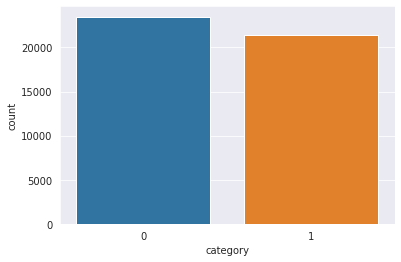

In [19]:
sns.set_style("darkgrid")
sns.countplot(df.category)

In [20]:
df.head()

title  ... category
0  As U.S. budget fight looms, Republicans flip t...  ...        1
1  U.S. military to accept transgender recruits o...  ...        1
2  Senior U.S. Republican senator: 'Let Mr. Muell...  ...        1
3  FBI Russia probe helped by Australian diplomat...  ...        1
4  Trump wants Postal Service to charge 'much mor...  ...        1

[5 rows x 5 columns]

In [21]:
df.isna().sum() # Checking for nan Values

title       0
text        0
subject     0
date        0
category    0
dtype: int64

In [22]:
df.title.count()

44898

In [23]:
df.subject.value_counts()

politicsNews       11272
worldnews          10145
News                9050
politics            6841
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: subject, dtype: int64

[Text(0, 0, 'politicsNews'),
 Text(0, 0, 'worldnews'),
 Text(0, 0, 'News'),
 Text(0, 0, 'politics'),
 Text(0, 0, 'Government News'),
 Text(0, 0, 'left-news'),
 Text(0, 0, 'US_News'),
 Text(0, 0, 'Middle-east')]

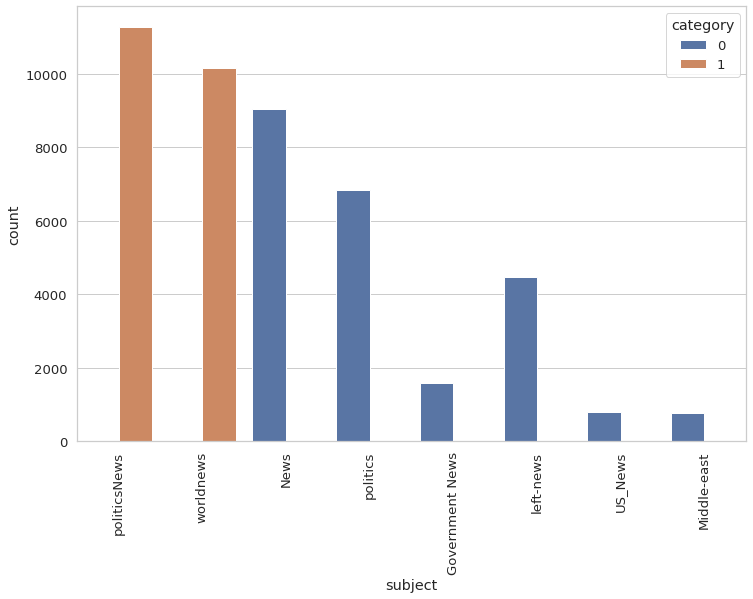

In [24]:
plt.figure(figsize = (12,8))
sns.set(style = "whitegrid",font_scale = 1.2)
chart = sns.countplot(x = "subject", hue = "category" , data = df)
chart.set_xticklabels(chart.get_xticklabels(),rotation=90)

SINCE THE TOPICS IN SUBJECT COLUMN ARE DIFFERENT FOR BOTH CATEGORIES, HENCE WE HAVE TO EXCLUDE IT FROM FINAL TEXT COLUMN

In [25]:
df['text'] = df['text'] + " " + df['title']
del df['title']
del df['subject']
del df['date']

In [26]:
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

DATA CLEANING

In [27]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)
#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)
#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text
#Apply function on review column
df['text']=df['text'].apply(denoise_text)

word cloud for label 1 ( Real data)

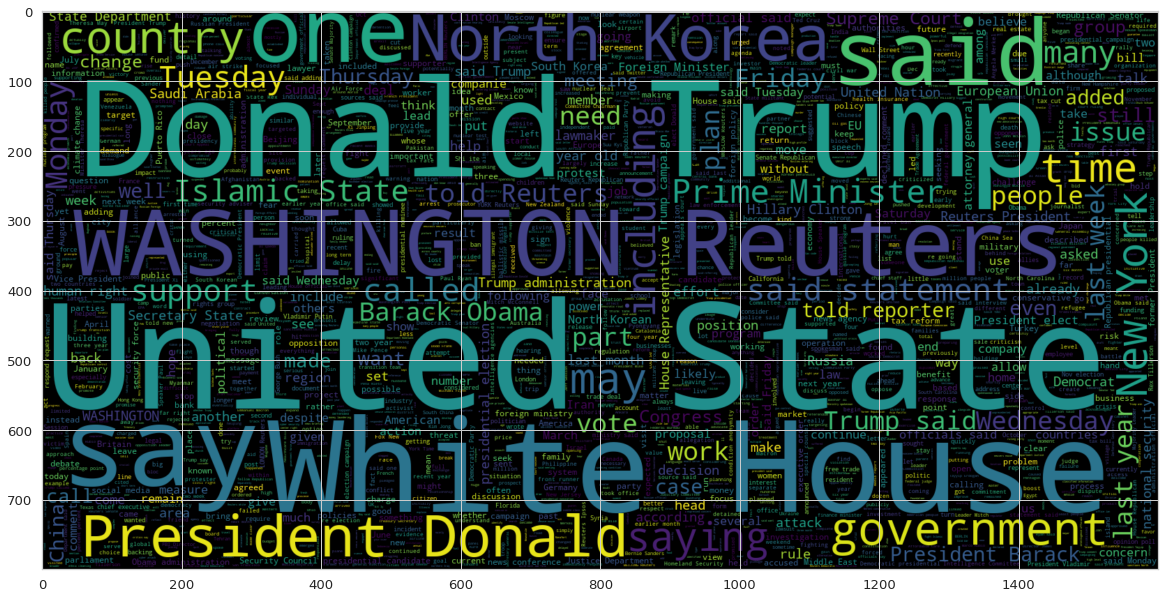

In [28]:
plt.figure(figsize = (20,20)) # Text that is not Fake
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(df[df.category == 1].text))
plt.imshow(wc , interpolation = 'bilinear')

Word count for fake data (label 0)

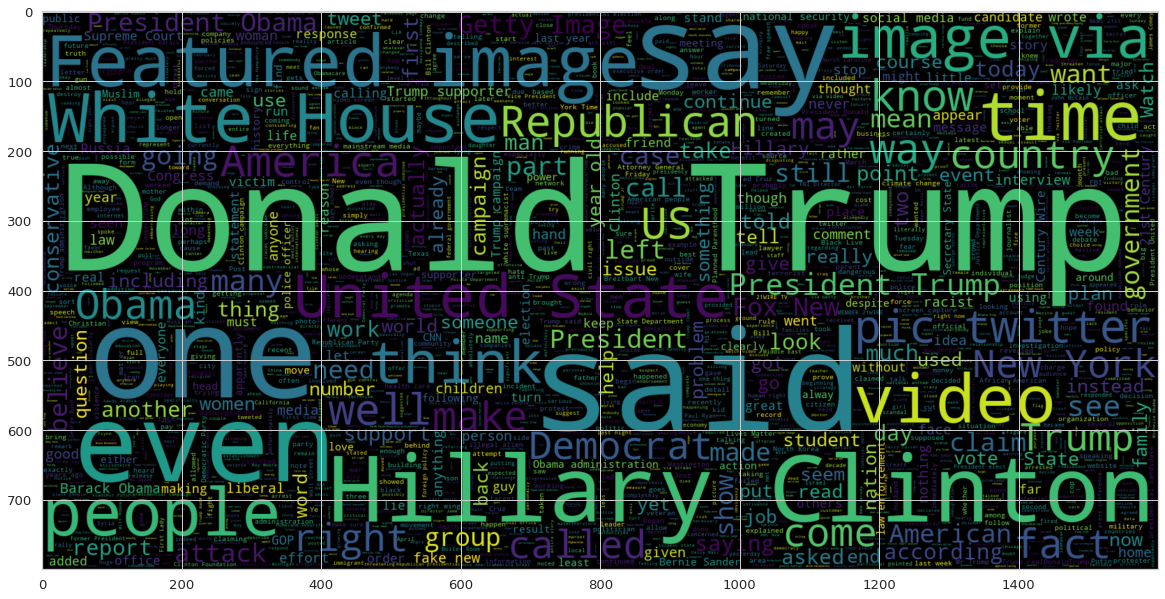

In [29]:
plt.figure(figsize = (20,20)) # Text that is Fake
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(df[df.category == 0].text))
plt.imshow(wc , interpolation = 'bilinear')

# Number of charcters in the text

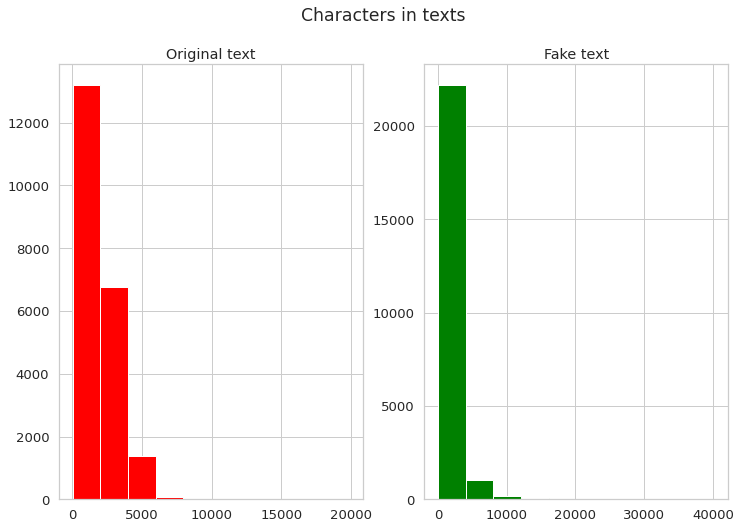

In [30]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
text_len=df[df['category']==1]['text'].str.len()
ax1.hist(text_len,color='red')
ax1.set_title('Original text')
text_len=df[df['category']==0]['text'].str.len()
ax2.hist(text_len,color='green')
ax2.set_title('Fake text')
fig.suptitle('Characters in texts')
plt.show()

The distribution of both seems to be a bit different. 2500 characters in text is the most common in original text category while around 5000 characters in text are most common in fake text category.

# Average word length in each Text

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0.98, 'Average word length in each text')

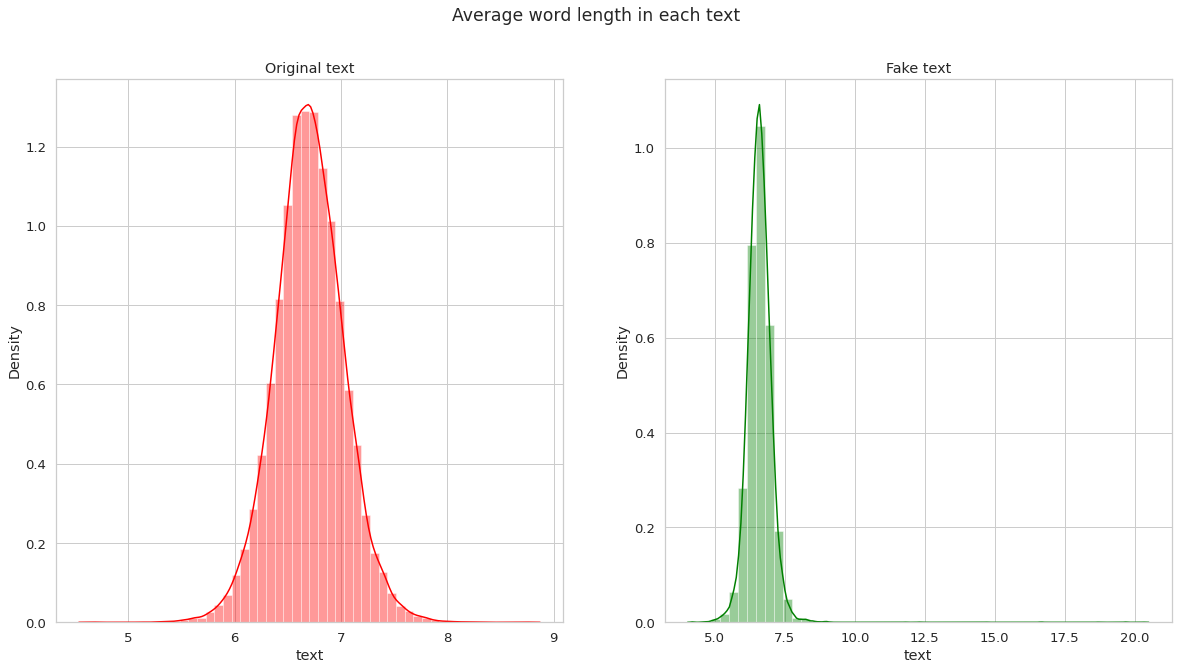

In [31]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
word=df[df['category']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('Original text')
word=df[df['category']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Fake text')
fig.suptitle('Average word length in each text')

In [32]:
def get_corpus(text):
    words = []
    for i in text:
        for j in i.split():
            words.append(j.strip())
    return words
corpus = get_corpus(df.text)
corpus[:5]

['WASHINGTON', '(Reuters)', 'head', 'conservative', 'Republican']

In [33]:
from collections import Counter
counter = Counter(corpus)
most_common = counter.most_common(10)
most_common = dict(most_common)
most_common

{'Donald': 27795,
 'President': 33180,
 'Trump': 111503,
 'U.S.': 50441,
 'also': 30325,
 'one': 29370,
 'people': 33115,
 'said': 93162,
 'said.': 26194,
 'would': 54613}

In [34]:
from sklearn.feature_extraction.text import CountVectorizer
def get_top_text_ngrams(corpus, n, g):
    vec = CountVectorizer(ngram_range=(g, g)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

# Unigrams

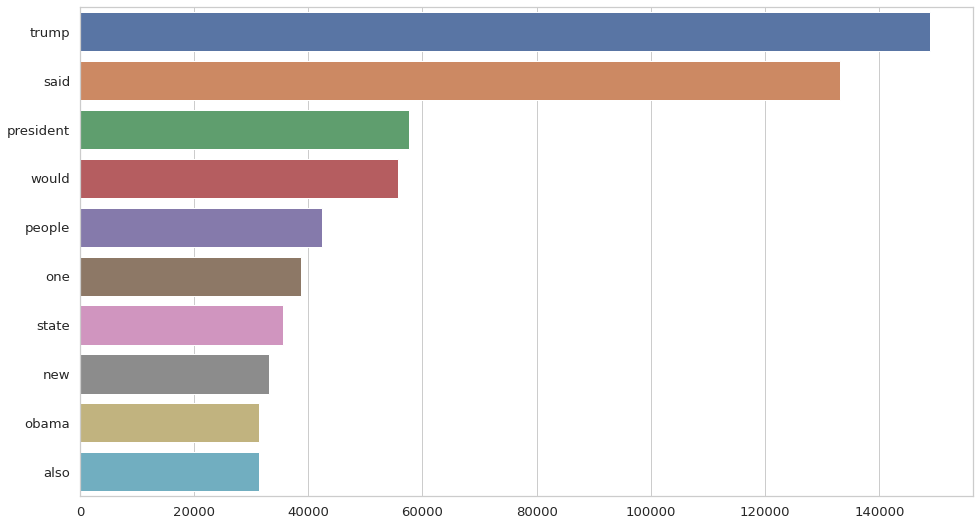

In [35]:
plt.figure(figsize = (16,9))
most_common_uni = get_top_text_ngrams(df.text,10,1)
most_common_uni = dict(most_common_uni)
sns.barplot(x=list(most_common_uni.values()),y=list(most_common_uni.keys()))

# Bigram Analysis

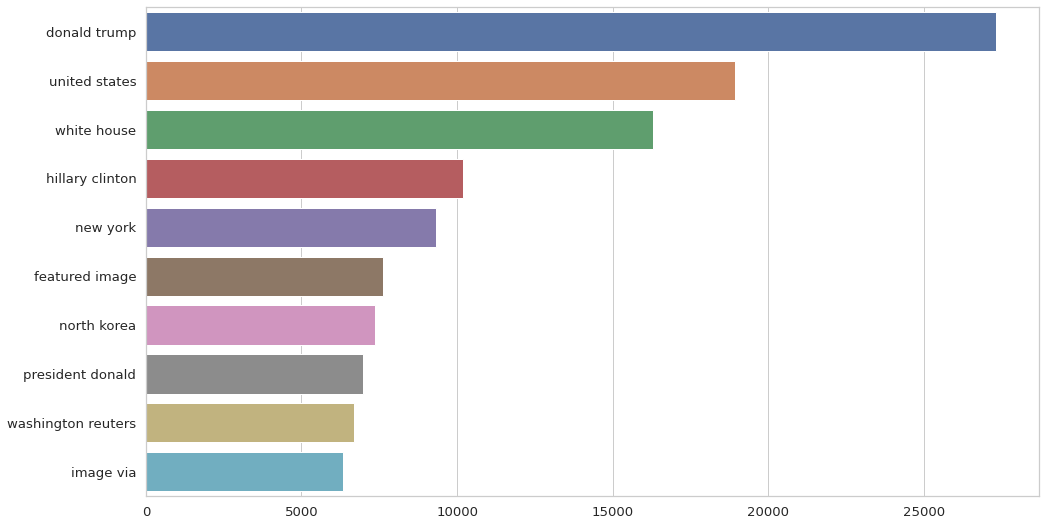

In [36]:
plt.figure(figsize = (16,9))
most_common_bi = get_top_text_ngrams(df.text,10,2)
most_common_bi = dict(most_common_bi)
sns.barplot(x=list(most_common_bi.values()),y=list(most_common_bi.keys()))

# Trigram Analysis

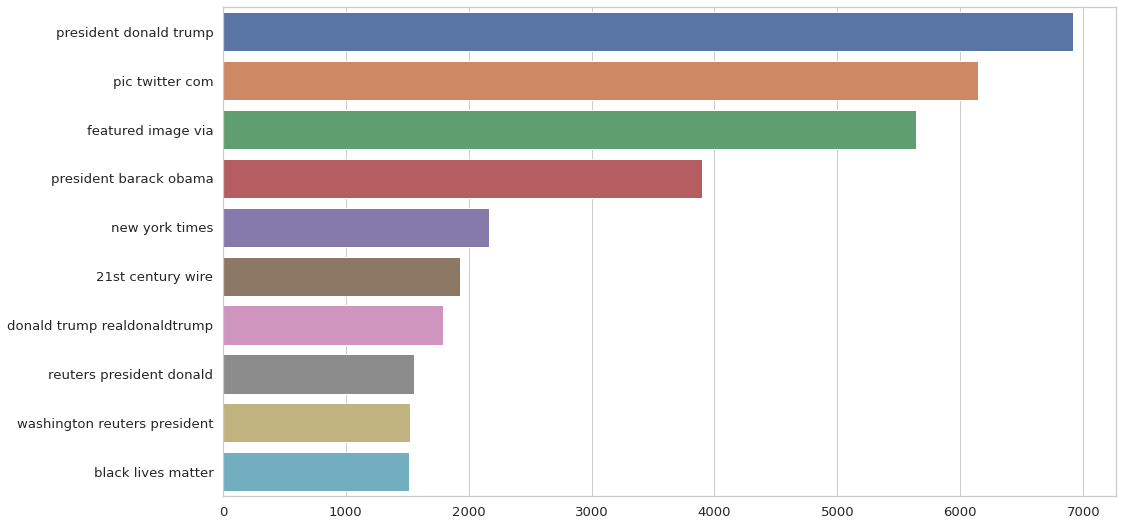

In [37]:
plt.figure(figsize = (16,9))
most_common_tri = get_top_text_ngrams(df.text,10,3)
most_common_tri = dict(most_common_tri)
sns.barplot(x=list(most_common_tri.values()),y=list(most_common_tri.keys()))

Splitting data 

In [38]:
x_train,x_test,y_train,y_test = train_test_split(df.text,df.category,random_state = 0)

In [39]:
max_features = 10000
maxlen = 300

Tokenizing Text -> Repsesenting each word by a number

Mapping of orginal word to number is preserved in word_index property of tokenizer

Tokenized applies basic processing like changing it to lower case, explicitely setting that as False

Lets keep all news to 300, add padding to news with less than 300 words and truncating long ones

In [40]:
tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(x_train)
tokenized_train = tokenizer.texts_to_sequences(x_train)
x_train = sequence.pad_sequences(tokenized_train, maxlen=maxlen)

In [41]:
tokenized_test = tokenizer.texts_to_sequences(x_test)
X_test = sequence.pad_sequences(tokenized_test, maxlen=maxlen)

In [42]:
EMBEDDING_FILE = PATH+'glove.twitter.27B.100d.txt'

In [43]:
def get_coefs(word, *arr): 
    return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE))

In [73]:
embeddings_index

{'<user>': array([ 0.63006  ,  0.65177  ,  0.25545  ,  0.018593 ,  0.043094 ,
         0.047194 ,  0.23218  ,  0.11613  ,  0.17371  ,  0.40487  ,
         0.022524 , -0.076731 , -2.2911   ,  0.094127 ,  0.43293  ,
         0.041801 ,  0.063175 , -0.64486  , -0.43657  ,  0.024114 ,
        -0.082989 ,  0.21686  , -0.13462  , -0.22336  ,  0.39436  ,
        -2.1724   , -0.39544  ,  0.16536  ,  0.39438  , -0.35182  ,
        -0.14996  ,  0.10502  , -0.45937  ,  0.27729  ,  0.8924   ,
        -0.042313 , -0.009345 ,  0.55017  ,  0.095521 ,  0.070504 ,
        -1.1781   ,  0.013723 ,  0.17742  ,  0.74142  ,  0.17716  ,
         0.038468 , -0.31684  ,  0.08941  ,  0.20557  , -0.34328  ,
        -0.64303  , -0.878    , -0.16293  , -0.055925 ,  0.33898  ,
         0.60664  , -0.2774   ,  0.33626  ,  0.21603  , -0.11051  ,
         0.0058673, -0.64757  , -0.068222 , -0.77414  ,  0.13911  ,
        -0.15851  , -0.61885  , -0.10192  , -0.47     ,  0.19787  ,
         0.42175  , -0.18458  ,  0.080

In [44]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
#change below line if computing normal stats is too slow
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: 
      continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
       embedding_matrix[i] = embedding_vector

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


In [80]:
embedding_matrix

array([[ 0.5177176 ,  0.35393376, -0.48751534, ..., -0.06818505,
         0.56177032, -0.77016146],
       [-0.24645001,  0.45247999,  0.83719999, ..., -0.98967999,
        -0.25141001, -0.54979002],
       [ 0.64024001,  0.77112001,  0.32822999, ..., -0.41058001,
         0.53272003, -0.01706   ],
       ...,
       [-0.11566   , -0.043444  ,  0.020861  , ...,  0.41229999,
         0.031898  ,  0.15177999],
       [-0.23291001, -0.48289001,  0.44578999, ..., -0.17361   ,
        -0.026722  ,  0.71455997],
       [-0.95275003,  0.82621002, -0.30743   , ...,  0.51024002,
         0.33712   ,  0.37779   ]])

# Model Training

In [46]:
batch_size = 256
epochs = 10
embed_size = 100

In [47]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)

In [49]:
#Defining Neural Network
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(max_features, output_dim=embed_size, weights=[embedding_matrix], input_length=maxlen, trainable=False))
#LSTM 
model.add(LSTM(units=128 , return_sequences = True , recurrent_dropout = 0.25 , dropout = 0.25))
model.add(LSTM(units=64 , recurrent_dropout = 0.1 , dropout = 0.1))
model.add(Dense(units = 32 , activation = 'relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile( loss='binary_crossentropy', metrics=['accuracy'])

In [50]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 300, 100)          1000000   
                                                                 
 lstm_2 (LSTM)               (None, 300, 128)          117248    
                                                                 
 lstm_3 (LSTM)               (None, 64)                49408     
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,168,769
Trainable params: 168,769
Non-trainable params: 1,000,000
_________________________________________________________________


In [52]:
history = model.fit(x_train, y_train, batch_size = batch_size , validation_data = (X_test,y_test) , epochs = 2 , callbacks = [learning_rate_reduction])

Epoch 1/2
132/132 [==============================] - 548s 4s/step - loss: 0.0860 - accuracy: 0.9680 - val_loss: 0.0563 - val_accuracy: 0.9824 - lr: 0.0010
Epoch 2/2
132/132 [==============================] - 543s 4s/step - loss: 0.0607 - accuracy: 0.9783 - val_loss: 0.1037 - val_accuracy: 0.9731 - lr: 0.0010


In [53]:
print("Accuracy of the model on Training Data is - " , model.evaluate(x_train,y_train)[1]*100 , "%")
print("Accuracy of the model on Testing Data is - " , model.evaluate(X_test,y_test)[1]*100 , "%")

1053/1053 [==============================] - 136s 129ms/step - loss: 0.0872 - accuracy: 0.9765
Accuracy of the model on Training Data is -  97.65390753746033 %
351/351 [==============================] - 45s 128ms/step - loss: 0.1037 - accuracy: 0.9731
Accuracy of the model on Testing Data is -  97.30957746505737 %


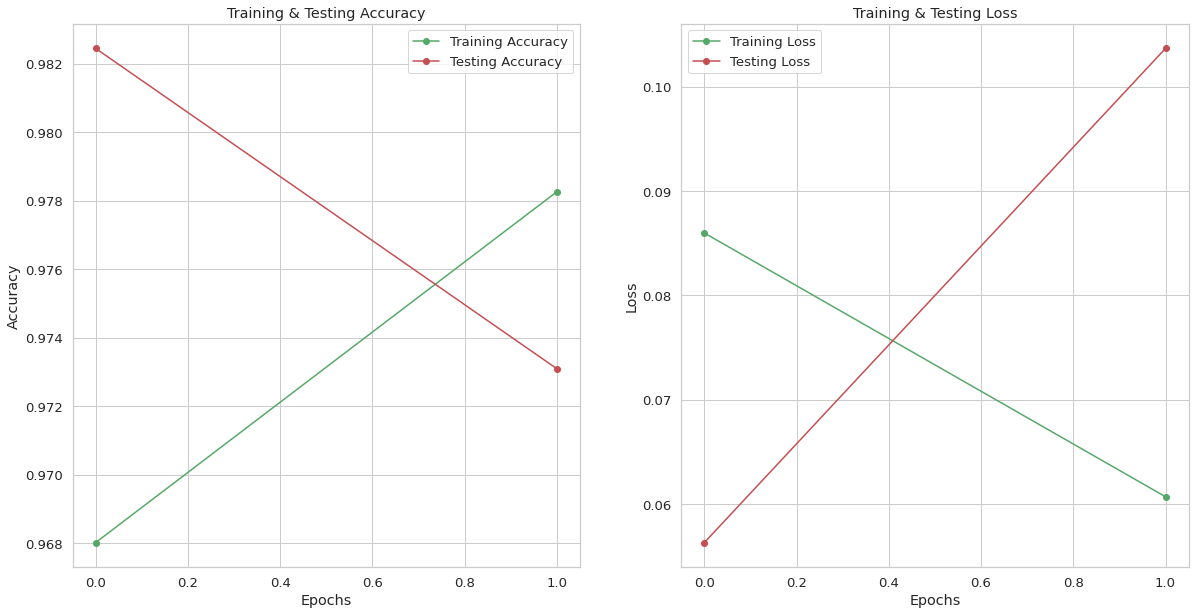

In [57]:
epochs = [i for i in range(2)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()


In [60]:
pred = model.predict(X_test)
pred[:5]

array([[1.8471479e-04],
       [5.2245334e-05],
       [6.3407657e-05],
       [9.6305987e-05],
       [9.8319328e-01]], dtype=float32)

In [67]:
threshold=0.5
pred=np.where(pred > threshold, 1,0)

In [68]:
print(classification_report(y_test, pred, target_names = ['Fake','Not Fake']))

              precision    recall  f1-score   support

        Fake       0.95      1.00      0.97      5858
    Not Fake       1.00      0.95      0.97      5367

    accuracy                           0.97     11225
   macro avg       0.98      0.97      0.97     11225
weighted avg       0.97      0.97      0.97     11225



In [69]:
cm = confusion_matrix(y_test,pred)
cm

array([[5845,   13],
       [ 289, 5078]])

In [70]:
cm = pd.DataFrame(cm , index = ['Fake','Original'] , columns = ['Fake','Original'])

Text(18.499999999999996, 0.5, 'Actual')

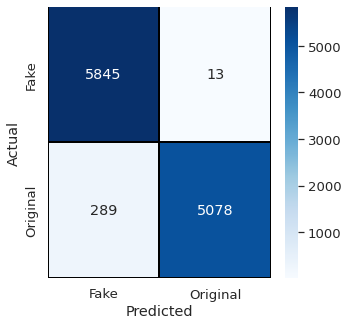

In [72]:
plt.figure(figsize = (5,5))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Fake','Original'] , yticklabels = ['Fake','Original'])
plt.xlabel("Predicted")
plt.ylabel("Actual")